## Python notebook 
V nasledujúcom notebooku sú popísané Python metódy použité pre trénovanie SOM mapy a optimalizácie jej parametrov. Obsah notebooku je nasledujúci:
1. Import potrebných knižníc
2. Predspracovanie dát
3. Vytvorenie SOM mapy
4. Optimalizácia parametrov SOM mapy

# 1. Import potrebných knižníc

In [1]:
!pip install minisom
!pip install hyperopt

  Created wheel for minisom: filename=MiniSom-2.3.0-py3-none-any.whl size=9020 sha256=b125df415481f7ff73e7d04d098f10ffa4c166d3bcfa0e06776401bab719572b
  Stored in directory: /home/jovyan/.cache/pip/wheels/6d/4e/9e/a95c14a232a196c22d9c04b221ff5d25461a1a4c55339c61db
Successfully built minisom
     |████████████████████████████████| 1.6 MB 7.3 MB/s eta 0:00:01
     |████████████████████████████████| 829 kB 52.4 MB/s eta 0:00:01
     |████████████████████████████████| 198 kB 42.3 MB/s eta 0:00:01
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491058 sha256=a017c579a55d35efffb3a9b795ab74438f458ff270800f7abe4371ca8d6b61fe
  Stored in directory: /home/jovyan/.cache/pip/wheels/8e/70/28/3d6ccd6e315f65f245da085482a2e1c7d14b90b30f239e2cf4
Successfully built future
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 1.7.0 requires dataclasses, w

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.close('all')

from IPython.display import Image, display
import matplotlib.pyplot as plt
from minisom import MiniSom
import numpy as np
import pandas as pd
import time
import pickle

from pylab import plot, axis, show, pcolor, colorbar, bone

from hyperopt import fmin, tpe, hp
from hyperopt import Trials, STATUS_OK

from mpl_toolkits.axes_grid1 import ImageGrid

# 2. Predspracovanie dát
Dáta načítame a predspracujeme do podoby vhodne pre model SOM.

In [3]:
#načítanie dát pre clustering
data = pickle.load(open('data/data_2014_11.pkl', 'rb'))
label = pickle.load(open('data/label_2014_11.pkl', 'rb'))
img_name = pickle.load(open('data/img_name.pkl', 'rb'))

In [4]:
data.shape

(13647, 150, 40, 3)

In [5]:
label.shape

(13647,)

In [6]:
#normalizácia a reshape
som_data = (data - data.min()) / (data.max() - data.min())
som_data = som_data.reshape(13647, -1)
print(som_data[0])

[0.87058824 0.89019608 0.18431373 ... 0.         0.         0.        ]


In [7]:
target = label
som_data.shape

(13647, 18000)

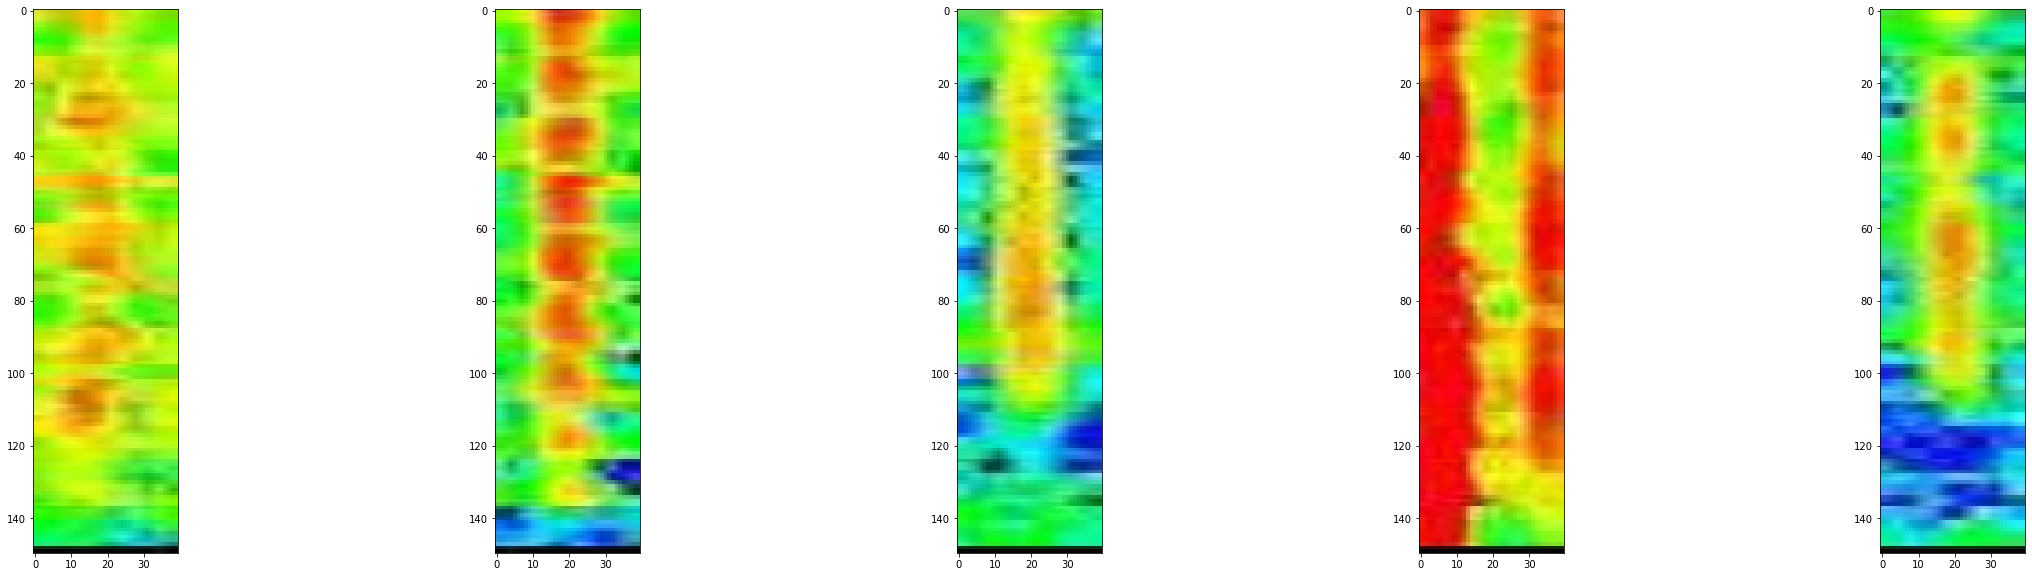

In [8]:
#vizualizácia dát
f, ax = plt.subplots(1,5)
f.set_size_inches(40, 10)
for i in range(5):
    ax[i].imshow(som_data[i].reshape(150, 40, 3))
plt.show()

# 3. Vytvorenie SOM mapy

Mapu natrénujeme s prednastavenými parametrami a vizualizujeme ju.

In [12]:
#nastavenie parametrov učenia SOM mapy
x = 3
y = 3
input_len = som_data.shape[1]
sigma = 1
learning_rate = 0.5
iterations = 100
seed = 42

In [13]:
data = som_data
som = MiniSom(x=x,
             y=y,
             input_len=input_len,
             sigma=sigma,
             learning_rate=learning_rate,
             random_seed = seed)
som.random_weights_init(data)

In [14]:
#trénovanie SOM mapy
start_time = time.time()
som.train_random(data, iterations)
elapsed_time = time.time()-start_time
print(elapsed_time, " seconds")

0.18378376960754395  seconds


In [15]:
win_map = som.win_map(data)

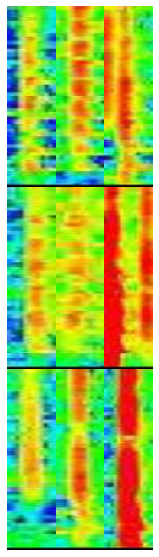

In [16]:
#vizualizácia mapy
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(20, 10))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(y, x), axes_pad=0)

def place_image(i, img):
    img = img
    grid[i].imshow(img.reshape(150, 40, 3))
    grid[i].axis('off')

to_fill = []
collided = []

for i in range(y*x):
    position = np.unravel_index(i, (y, x))
    if position in win_map:
        img = win_map[position][0]
        collided += win_map[position][1:]
        place_image(i, img)
    else:
        to_fill.append(i)

collided = collided[::-1]
for i in to_fill:
    position = np.unravel_index(i, (y, x))
    img = collided.pop()
    place_image(i, img)
plt.savefig('som_img/som_3_3_no_opti.png')
#plt.show()

# 4. Optimalizácia parametrov SOM mapy

V prvom kroku optimalizujeme len parameter sigma a v druhom kroku optimalizujeme aj parameter learning_rate. Mapy s optimalizovanými parametrami natrénujeme a vizualizujeme.

In [17]:
#funkcia na trénovanie mapy
def train_som(x, y, input_len, sigma, learning_rate, seed):
    #init
    som = MiniSom(x=x,
             y=y,
             input_len=input_len,
             sigma=sigma,
             learning_rate=learning_rate, random_seed = seed)
    som.random_weights_init(data)
    #training
    start_time = time.time()
    som.train_random(data, iterations)
    elapsed_time = time.time()-start_time
    print(elapsed_time, " seconds")
    return som

In [18]:
#sigma optimalizácia
start_time = time.time()
best = fmin(
    fn=lambda sig: MiniSom(x=x,
                          y=y,
                          input_len=input_len,
                          sigma=sig,
                          learning_rate=learning_rate,
                          random_seed = seed).quantization_error(data),
    space=hp.uniform("sig", 0.001, x/2.01),
    algo=tpe.suggest,
    max_evals=200)
elapsed_time = time.time()-start_time
print(elapsed_time, " seconds")
print(best)

100%|██████████| 200/200 [17:54<00:00,  5.37s/trial, best loss: 82.72995835942969]
1074.4701209068298  seconds
{'sig': 0.7005065527450522}


In [19]:
#aktualizácia parametra sigma
sigma = best['sig']
print("x: {}\ny: {}\ninput_len: {}\nsigma: {}\nlearning_rate: {}\nrandom_seed: {}".format(x,
                                                                        y,
                                                                        input_len,
                                                                        sigma,
                                                                        learning_rate,
                                                                        seed))

x: 3
y: 3
input_len: 18000
sigma: 0.7005065527450522
learning_rate: 0.5
random_seed: 42


In [20]:
#trénovanie mapy s aktualizovaným parametrom sigma
som = train_som(x, y, input_len, sigma, learning_rate, seed)

0.11394095420837402  seconds


In [21]:
win_map = som.win_map(data)

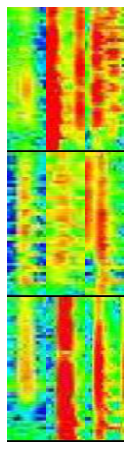

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(20, 8))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(y, x), axes_pad=0)

def place_image(i, img):
    img = img
    grid[i].imshow(img.reshape(150, 40, 3))
    grid[i].axis('off')

to_fill = []
collided = []

for i in range(y*x):
    position = np.unravel_index(i, (y, x))
    if position in win_map:
        img = win_map[position][0]
        collided += win_map[position][1:]
        place_image(i, img)
    else:
        to_fill.append(i)

collided = collided[::-1]
for i in to_fill:
    position = np.unravel_index(i, (y, x))
    img = collided.pop()
    place_image(i, img)
plt.savefig('som_img/som_3_3_sig_opti.png')
#plt.show()

In [29]:
#optimalizácia sigma a learning rate
space = {
    'sig': hp.uniform('sig', 0.001, 5),
    'learning_rate': hp.uniform('learning_rate', 0.001, 5)
    }

def som_fn(space):
    sig = space['sig']
    learning_rate = space['learning_rate']
    val = MiniSom(x=x,
                  y=y,
                  input_len=input_len,
                  sigma=sig,
                  learning_rate=learning_rate, random_seed=seed).quantization_error(data)
    #print(val)
    return{'loss': val, 'status': STATUS_OK}

trials = Trials()
best = fmin(fn=som_fn,
           space=space,
           algo=tpe.suggest,
           max_evals=50,
           trials=trials)

print('best: {}'.format(best))

for i, trial in enumerate(trials.trials[:2]):
    print(i, trial)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

/opt/conda/lib/python3.8/site-packages/minisom.py:160: UserWarning: Warning: sigma is too high for the dimension of the map.
  warn('Warning: sigma is too high for the dimension of the map.')



100%|██████████| 50/50 [05:04<00:00,  6.09s/trial, best loss: 82.72995835942969]
best: {'learning_rate': 2.11865332222016, 'sig': 3.720369282416145}
0 {'state': 2, 'tid': 0, 'spec': None, 'result': {'loss': 82.72995835942969, 'status': 'ok'}, 'misc': {'tid': 0, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'learning_rate': [0], 'sig': [0]}, 'vals': {'learning_rate': [2.11865332222016], 'sig': [3.720369282416145]}}, 'exp_key': None, 'owner': None, 'version': 0, 'book_time': datetime.datetime(2022, 3, 12, 15, 14, 4, 914000), 'refresh_time': datetime.datetime(2022, 3, 12, 15, 14, 11, 56000)}
1 {'state': 2, 'tid': 1, 'spec': None, 'result': {'loss': 82.72995835942969, 'status': 'ok'}, 'misc': {'tid': 1, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'learning_rate': [1], 'sig': [1]}, 'vals': {'learning_rate': [1.4480319517678135], 'sig': [2.98063372273186]}}, 'exp_key': None, 'owner': None, 'version': 0, 'book_time': datetime.datetim

Pri optimalizácii parametrov takto malej mapy vznikol problém s príliš veľkou hodnotou sigma. Vizualizovaná mapa taktiež nevyzerá dobre. Preto sme sa rozhodli použiť v konečnej SOM mape hodnotu sigma z predchádzajúcej optimalizácie.

In [30]:
#aktualizácia parametrov sigma a learning rate
sigma = best['sig']
learning_rate = best['learning_rate']
print("x: {}\ny: {}\ninput_len: {}\nsigma: {}\nlearning_rate: {}\nrandom_seed: {}".format(x,
                                                                        y,
                                                                        input_len,
                                                                        sigma,
                                                                        learning_rate,
                                                                        seed))

x: 3
y: 3
input_len: 18000
sigma: 3.720369282416145
learning_rate: 2.11865332222016
random_seed: 42


In [31]:
som = train_som(x, y, input_len, sigma, learning_rate, seed)

0.10893464088439941  seconds


In [32]:
win_map = som.win_map(data)

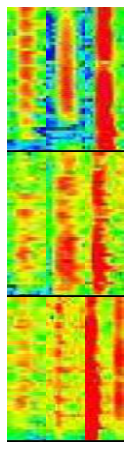

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(20, 8))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(y, x), axes_pad=0)

def place_image(i, img):
    img = img
    grid[i].imshow(img.reshape(150, 40, 3))
    grid[i].axis('off')

to_fill = []
collided = []

for i in range(y*x):
    position = np.unravel_index(i, (y, x))
    if position in win_map:
        img = win_map[position][0]
        collided += win_map[position][1:]
        place_image(i, img)
    else:
        to_fill.append(i)

collided = collided[::-1]
for i in to_fill:
    position = np.unravel_index(i, (y, x))
    img = collided.pop()
    place_image(i, img)
plt.savefig('som_img/som_3_3_sigrate_opti.png')
#plt.show()